In [1]:
import sys
sys.path.append('../')

In [2]:
import json
from zipfile import ZipFile
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from sklearn.neighbors import KernelDensity

from data_loading import ChatHighlightData
import utils

## Video info from zipped download

In [8]:
vid_info = list()

info_files_path = "../data/video_info/*_vids.json"
info_files = glob.glob(info_files_path)

for f_name in info_files:
    with open(f_name, "r") as info_file:
        vid_info.extend(json.load(info_file))

# for lookup later
vid2ind = {v["id"]:i for i, v in enumerate(vid_info)}

In [9]:
vid_info[vid2ind["83571434"]]

{'id': '83571434',
 'stream_id': '22827014832',
 'user_id': '30707866',
 'user_login': 'esl_lol',
 'user_name': 'ESL_LOL',
 'title': 'RERUN: fnatic vs. Millenium - Group A - IEM Katowice 2014 - League of Legends',
 'description': '',
 'created_at': '2016-08-14T14:26:23Z',
 'published_at': '2016-08-14T14:26:23Z',
 'url': 'https://www.twitch.tv/videos/83571434',
 'thumbnail_url': 'https://static-cdn.jtvnw.net/cf_vods/d2nvs31859zcd8/ad3ef727c7_esl_lol_22827014832_500493871/thumb/thumb0-%{width}x%{height}.jpg',
 'viewable': 'public',
 'view_count': 36,
 'language': 'en',
 'type': 'archive',
 'duration': '18h30m39s',
 'muted_segments': None}

In [49]:
chat_files_path = "../data/videos_chat/*_vids_chat.zip"
chat_files = glob.glob(chat_files_path)


for chat_file_name in chat_files:
    zf = ZipFile(chat_file_name)
    for f_name in zf.namelist():
        # print(f_name)if f_name.endswith("json") else None
        if f_name.endswith("json"):
            with zf.open(f_name, "r") as in_file:
                vid_chat = json.load(in_file)
                v_ind = vid2ind[f_name.split("/")[-1].strip(".json")]
                chat_info = {
                    "msg_count": len(vid_chat["comments"]),
                    "is_rerun": vid_info[v_ind]["title"].startswith("RERUN") or vid_info[v_ind]["title"].startswith("REBROADCAST") # might want to add more filters in future
                }

                vid_info[v_ind].update(chat_info)

In [16]:
vid_info_filtered = [vinf for vinf in vid_info if "msg_count" in vinf.keys()]

## Video info into dataframe

In [3]:
"""
cols = ["id", "title", "created_at", "msg_count", "is_rerun", "duration"]

df_vid_info = pd.DataFrame(vid_info_filtered, columns=cols)
df_vid_info["created_at"] = pd.to_datetime(df_vid_info["created_at"])
"""
df_vid_info = pd.read_csv("../data/video_info/vid_info.csv")
df_vid_info = df_vid_info.drop("Unnamed: 0", axis=1)
df_vid_info = df_vid_info.set_index("id")
#df_vid_info

In [4]:
df_msg_info = pd.read_csv("../data/video_info/msg_info.csv")
df_msg_info = df_msg_info.set_index("Unnamed: 0")
df_msg_info.index.name = "id"
df_msg_info["num_tokens"] = df_msg_info.apply(lambda x: 0 if x["num_chars"]==0 else x["num_tokens"] ,axis=1)
df_msg_info["longest_message_toks"] = df_msg_info.apply(lambda x: 0 if x["num_chars"]==0 else x["longest_message_toks"] ,axis=1)
df_msg_info["shortest_message_toks"] = df_msg_info.apply(lambda x: 0 if x["num_chars"]==0 else x["shortest_message_toks"] ,axis=1)
#df_msg_info

In [5]:
df_vid_info = pd.concat([df_vid_info, df_msg_info], ignore_index=False, axis=1)
df_vid_info = df_vid_info.drop(["longest_message_toks", "shortest_message_toks", "longest_message_chars", "shortest_message_chars"], axis=1)
df_vid_info

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars
id,,,,,,,
3590598,TLC Winter 2014 W5D2 IFF vs TCC,2014-12-07 05:58:17+00:00,0,False,5h0m17s,0,0
3597104,GPL 2015 W1 D1,2014-12-10 09:35:01+00:00,0,False,4h31m27s,0,0
3599435,GPL Spring 2015 W1D2,2014-12-11 09:26:38+00:00,0,False,4h32m7s,0,0
3601673,GPL Spring 2015 W1D3,2014-12-12 09:34:23+00:00,0,False,4h20m49s,0,0
3615234,GPL Spring 2015 W2D1,2014-12-17 09:43:50+00:00,0,False,4h14m10s,0,0
...,...,...,...,...,...,...,...
1417245159,Week 8 Day 3 - 2022 Spring LEC,2022-03-06 14:20:51+00:00,55768,False,6h48m58s,245733,1113588
1417645450,IMT vs TL - Week 5 Day 2 | LCS Spring Split (2...,2022-03-06 21:10:14+00:00,117,False,4h19m7s,319,2634
1417946885,(Rebroadcast) Week 8 Day 3 - 2022 Spring LEC,2022-03-07 01:57:31+00:00,254,False,5h47m55s,864,6768


In [6]:
hours, dur = zip(*[d.split("h") if "h" in d else (0,d) for d in df_vid_info.duration])
minutes, dur = zip(*[d.split("m") if "m" in d else (0,d) for d in dur])
seconds, _ = zip(*[d.split("s") if "s" in d else (0,d) for d in dur])

hours = np.asarray(hours, dtype=int)
minutes = np.asarray(minutes, dtype=int)
seconds = np.asarray(seconds, dtype=int)

df_vid_info["duration_hrs"] = hours + minutes/60 + seconds/(60*60)

In [7]:
#delete 0 length stream
df_vid_info = df_vid_info.drop(df_vid_info[df_vid_info["duration_hrs"] == 0].index)

In [8]:
rerun_markers = ["(RE-BROADCAST)", "(REBROADCAST)","REBROADCAST:","RERUNL:","RERUN:","Rerun:","[Rebroadcast]","RERUN","REBROADCAST"]

In [9]:
df_vid_info["is_rerun"] = df_vid_info.apply(lambda x: bool(min(1, x["is_rerun"] + sum([x["title"].startswith(k) for k in rerun_markers]))), axis=1).to_numpy()

In [10]:
df_vid_info["msg_per_min"] = df_vid_info.apply(lambda x: x["msg_count"]/(x["duration_hrs"]*60),axis=1)

In [11]:
df_vid_info

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,duration_hrs,msg_per_min
id,,,,,,,,,
3590598,TLC Winter 2014 W5D2 IFF vs TCC,2014-12-07 05:58:17+00:00,0,False,5h0m17s,0,0,5.004722,0.000000
3597104,GPL 2015 W1 D1,2014-12-10 09:35:01+00:00,0,False,4h31m27s,0,0,4.524167,0.000000
3599435,GPL Spring 2015 W1D2,2014-12-11 09:26:38+00:00,0,False,4h32m7s,0,0,4.535278,0.000000
3601673,GPL Spring 2015 W1D3,2014-12-12 09:34:23+00:00,0,False,4h20m49s,0,0,4.346944,0.000000
3615234,GPL Spring 2015 W2D1,2014-12-17 09:43:50+00:00,0,False,4h14m10s,0,0,4.236111,0.000000
...,...,...,...,...,...,...,...,...,...
1417245159,Week 8 Day 3 - 2022 Spring LEC,2022-03-06 14:20:51+00:00,55768,False,6h48m58s,245733,1113588,6.816111,136.363192
1417645450,IMT vs TL - Week 5 Day 2 | LCS Spring Split (2...,2022-03-06 21:10:14+00:00,117,False,4h19m7s,319,2634,4.318611,0.451534
1417946885,(Rebroadcast) Week 8 Day 3 - 2022 Spring LEC,2022-03-07 01:57:31+00:00,254,False,5h47m55s,864,6768,5.798611,0.730060


In [12]:
df_vid_info[df_vid_info.msg_count.isna()] # missing videos

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,duration_hrs,msg_per_min
id,,,,,,,,,


In [13]:
df_vid_info.describe()

,msg_count,num_tokens,num_chars,duration_hrs,msg_per_min
count,5953.000000,5.953000e+03,5.953000e+03,5953.000000,5953.000000
mean,15733.779607,6.803065e+04,3.042220e+05,6.361180,43.619916
std,34000.960054,1.699190e+05,7.656217e+05,8.103318,80.568819
min,0.000000,0.000000e+00,0.000000e+00,0.000278,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,2.897778,0.000000
50%,1229.000000,5.878000e+03,2.562200e+04,5.471111,7.998690
75%,14297.000000,6.111500e+04,2.661150e+05,6.876667,46.996744
max,409973.000000,2.459735e+06,1.467572e+07,89.180833,586.882192


In [14]:
df_vid_info[(df_vid_info.msg_count.to_numpy() < 15500) & (df_vid_info.msg_count.to_numpy() > 14500)].sort_values(["msg_per_min"], ascending=False)

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,duration_hrs,msg_per_min
id,,,,,,,,,
708902829,V5 vs. FPX - Playoff Round1 | LPL Summer Split...,2020-08-13 10:28:34+00:00,15293,False,2h4m22s,47813,199863,2.072778,122.967033
70062989,LCK Summer - Week 2 Day 4: SKT vs. CJ (OGN),2016-06-02 10:43:42+00:00,15120,False,2h10m31s,51507,243101,2.175278,115.847274
68694328,LCK Summer - Week 1 Day 2: ROX vs. SSG (OGN),2016-05-26 10:46:49+00:00,14758,False,2h42m2s,55564,247704,2.700556,91.080025
222680899,LLN Apertura 2018 S2 Día 1,2018-01-26 22:45:23+00:00,15163,False,3h21m16s,49979,228260,3.354444,75.337860
600099810,EDG vs. RNG - Playoff Round 1 | LPL Spring (2020),2020-04-23 09:29:14+00:00,15310,False,3h24m41s,59092,245202,3.411389,74.798469
69681647,LCK Summer - Week 2 Day 1: ESC vs. JAG (OGN),2016-05-31 10:46:28+00:00,14727,False,3h48m16s,60993,281331,3.804444,64.516647
72910772,LCK Summer - Week 4 Day 5: JAG vs. SKT | ROX v...,2016-06-17 09:14:10+00:00,15378,False,4h4m27s,55521,245304,4.074167,62.908570
222689528,NA Academy: Clutch Gaming vs. Counter Logic Ga...,2018-01-26 23:10:49+00:00,15379,False,4h9m12s,64848,282195,4.153333,61.713483
313203595,LCK Spring Promotion: BTC vs. MVP,2018-09-22 07:33:34+00:00,15030,False,4h5m35s,61014,277809,4.093056,61.201222


In [15]:
df_vid_info.sort_values("duration_hrs", ascending=False)

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,duration_hrs,msg_per_min
id,,,,,,,,,
30009722,RERUN: Team WE vs. TSM - IEM Katowice 2015 - G...,2013-12-26 22:08:10+00:00,0,True,89h10m51s,0,0,89.180833,0.000000
51850869,RERUN: Team Curse vs Gambit Gaming - Group A -...,2016-03-02 05:20:58+00:00,3791,True,47h57m9s,18531,72453,47.952500,1.317623
67804358,RERUN: Azubu Frost vs Gambit Gaming - Match 2 ...,2016-05-21 20:44:50+00:00,240,True,47h57m5s,1009,3948,47.951389,0.083418
61083342,RERUN: fnatic vs SK Telecom T1 Game 2 - IEM Co...,2016-04-17 01:21:51+00:00,365,True,47h57m5s,1289,5106,47.951389,0.126865
30986044,RERUN: Team SoloMid vs. LGD Gaming - IEM 2015 ...,2015-12-20 21:34:30+00:00,0,True,47h57m4s,0,0,47.951111,0.000000
...,...,...,...,...,...,...,...,...,...
30072948,2015 All-Star Event Rebroadcast - Day 4,2015-01-16 04:43:04+00:00,0,False,6s,0,0,0.001667,0.000000
30006333,RERUN: Team WE vs. TSM - IEM Katowice 2015 - G...,2015-03-30 16:03:41+00:00,0,True,5s,0,0,0.001389,0.000000
38127627,Riot Season 2 World Finals -- Playoffs,2012-10-06 20:52:48+00:00,0,False,5s,0,0,0.001389,0.000000


In [16]:
df_vid_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5953 entries, 3590598 to 1419109090
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         5953 non-null   object 
 1   created_at    5953 non-null   object 
 2   msg_count     5953 non-null   int64  
 3   is_rerun      5953 non-null   bool   
 4   duration      5953 non-null   object 
 5   num_tokens    5953 non-null   int64  
 6   num_chars     5953 non-null   int64  
 7   duration_hrs  5953 non-null   float64
 8   msg_per_min   5953 non-null   float64
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 424.4+ KB


In [17]:
#vid_info_out = "../data/videos_chat/vid_info.csv"
#df_vid_info.to_csv(vid_info_out)

In [18]:
df_commented_vids = df_vid_info[df_vid_info.msg_count > 0]
f"{df_commented_vids.title.count()}/{df_vid_info.title.count()} videos with comments"

'4072/5953 videos with comments'

In [19]:
df_reruns = df_vid_info[df_vid_info.is_rerun]
print(f"{df_reruns.title.count()}/{df_vid_info.title.count()} videos are reruns (approx)")

946/5953 videos are reruns (approx)


In [20]:
print(f"{sum(df_reruns.msg_count > 0)}/{df_reruns.title.count()} reruns have comments")

586/946 reruns have comments


In [21]:
print(f"{df_reruns.msg_count.mean()} comments per rerun video on average") # maybe an approximate cutoff for what to sort out

3697.881606765328 comments per rerun video on average


In [22]:
print(f"{df_commented_vids.msg_count.sum()} comments in total")

93663190 comments in total


In [23]:
print(f"{df_commented_vids.msg_count.mean()} comments per video on average")

23001.765717092338 comments per video on average


In [24]:
print(f"oldest video from\t{df_vid_info.created_at.min()}\nmost recent video from\t{df_vid_info.created_at.max()}")

oldest video from	2012-05-29 11:43:41+00:00
most recent video from	2022-03-08 07:48:50+00:00


In [25]:
print(f"oldest video with comments from\t{df_commented_vids.created_at.min()}\nmost recent video with comments from\t{df_commented_vids.created_at.max()}")

oldest video with comments from	2016-03-02 05:20:58+00:00
most recent video with comments from	2022-03-08 07:48:50+00:00


In [26]:
print(f"{df_commented_vids.msg_count.sum()/(df_commented_vids.duration_hrs.sum()*60)} comments per minute on average")

56.72665463889091 comments per minute on average


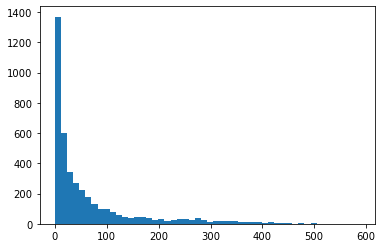

In [27]:
n, bins, _ = plt.hist(df_commented_vids.msg_per_min,bins=50)
plt.show()

In [28]:
list(zip(n[:5],bins[:5]))

[(1370.0, 0.0037859666834931843),
 (599.0, 11.74135408296626),
 (344.0, 23.47892219924903),
 (270.0, 35.2164903155318),
 (222.0, 46.954058431814566)]

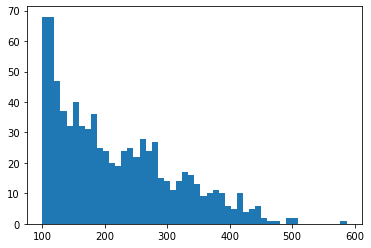

In [29]:
n, bins, _ = plt.hist(df_commented_vids.msg_per_min,bins=50, range=(100,df_commented_vids.msg_per_min.max()))
plt.show()

messages per minute helps us to characterize the VODs:

In [30]:
sum(n)

814.0

In [31]:
len(set(df_vid_info.title))

4035

In [32]:
df_vid_info.title.count()

5953

## Duplicates
There are no duplicated videos, however there are duplicated titles. This seems to stem from:

a) some titles being " " one whitespace only

b) some streams being stopped and restarted with the same title

In [33]:
df_vid_info[df_vid_info.duplicated()].title.count()

0

In [34]:
print(f"{df_vid_info.title.duplicated().sum()} duplicated titles")

1918 duplicated titles


In [35]:
set(df_vid_info[df_vid_info.title.duplicated()].title)

{' ',
 '   TLC Spring 2015 Singapore - W1D1 - RJB vs Exgs',
 '   TLC Spring 2015 Singapore - W1D2 - NYZ vs GR',
 '  LPL Summer: IM vs. LGD | OMG vs. WE | VG vs. RNG',
 ' GRF vs. JAG - AF vs. HLE | Week 10 Day 2 | LCK Summer Split (2019)',
 ' S04 vs RB Game 1 - EU CS 2017 Summer Season - Week 1',
 '(REBROADCAST) 2016 All-Star Event: Day 3',
 '(REBROADCAST) Academy Rush Week 3',
 '(REBROADCAST) EU LCS Spring: Week 1 Day 1',
 '(REBROADCAST) EU LCS Summer Split (2018) | Week 5 Day 1',
 '(REBROADCAST) EU LCS Summer: Week 6 Day 2',
 '(REBROADCAST) FNC vs. G2 | Final | EU LCS Spring | Fnatic vs. G2 Esports (2018)',
 '(REBROADCAST) MSI Play-In Knockout: EVOS Esports vs. BAUSuperMassive eSports',
 '(REBROADCAST) MSI Play-In Knockout: Flash Wolves vs. Gambit Esports',
 '(REBROADCAST) RNG v FNC | Semifinals | Mid-Season Invitational (2018)',
 '(REBROADCAST) RNG vs. EDG | Final | LPL Spring | Royal Never Give Up vs. Edward Gaming (2018)',
 '(REBROADCAST) Rift Rivals NA x EU: Day 1',
 '(REBROADCAST

In [36]:
df_vid_info[df_vid_info.title.duplicated()].sort_values("title")

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,duration_hrs,msg_per_min
id,,,,,,,,,
1155878474,,2021-09-22 10:55:28+00:00,29528,False,1h56m22s,101032,437020,1.939444,253.749642
448475597,,2019-07-05 06:24:35+00:00,13650,False,6h38m55s,61046,258773,6.648611,34.217673
1013003051,,2021-05-06 11:38:35+00:00,0,False,7h46m12s,0,0,7.770000,0.000000
1013003053,,2021-05-06 11:38:35+00:00,151294,False,7h46m12s,508195,2365022,7.770000,324.525955
1155878473,,2021-09-22 10:55:28+00:00,0,False,1h56m22s,0,0,1.939444,0.000000
...,...,...,...,...,...,...,...,...,...
1115898498,🔴 LIVE - ESL Mobile Open presents Wild Rift Oc...,2021-08-12 09:42:37+00:00,304,False,5h36m13s,1688,6804,5.603611,0.904179
164773191,🔴 LIVE: Return of the Legends - Team NA vs Te...,2017-08-06 01:50:57+00:00,8150,False,3h1m20s,28434,140569,3.022222,44.944853
160383776,🔴 [LIVE] ESL Premiership - 2017 Autumn Group S...,2017-07-19 17:48:04+00:00,1,False,4m48s,4,11,0.080000,0.208333


In [37]:
df_vid_info[df_vid_info.title == " "]

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,duration_hrs,msg_per_min
id,,,,,,,,,
368573688,,2019-01-23 17:52:34+00:00,54,False,4m25s,120,478,0.073611,12.226415
448475597,,2019-07-05 06:24:35+00:00,13650,False,6h38m55s,61046,258773,6.648611,34.217673
979788223,,2021-04-08 11:45:45+00:00,14460,False,5h9m25s,74225,435192,5.156944,46.733100
1013003051,,2021-05-06 11:38:35+00:00,0,False,7h46m12s,0,0,7.770000,0.000000
1013003053,,2021-05-06 11:38:35+00:00,151294,False,7h46m12s,508195,2365022,7.770000,324.525955
1155878473,,2021-09-22 10:55:28+00:00,0,False,1h56m22s,0,0,1.939444,0.000000
1155878474,,2021-09-22 10:55:28+00:00,29528,False,1h56m22s,101032,437020,1.939444,253.749642


In [38]:
df_vid_info[df_vid_info.title.duplicated()].sort_values("title").iloc[0].title

' '

some streams actually have no title https://www.twitch.tv/videos/1013003053

## Filtering out videos to reduce the number of messages

Discard videos without messages

In [39]:
df_reduced = df_vid_info[df_vid_info.msg_count > 0]
f"{df_commented_vids.title.count()}/{df_vid_info.title.count()} videos with comments"

'4072/5953 videos with comments'

discard reruns

In [40]:
# to look at stream titles, write them to file
# with open("stream_titles.txt", "w") as out_file:
#    out_file.write("\n".join(sorted(df_commented_vids.title.unique().tolist())))

In [41]:
df_reduced = df_reduced[df_reduced.is_rerun==False]

In [42]:
df_reduced = df_reduced[df_reduced["duration_hrs"] >= 1] # at least one hour long so you can theoretically find at least one match in the stream

In [43]:
# df_reduced = df_reduced[df_reduced["msg_per_min"] >= 300]

In [44]:
df_reduced.title.count(),df_reduced.msg_count.sum()

(3110, 89960287)

In [45]:
df_reduced.sort_values("duration_hrs", ascending=False)

,title,created_at,msg_count,is_rerun,duration,num_tokens,num_chars,duration_hrs,msg_per_min
id,,,,,,,,,
64357081,Go4LoL EUNE March Monthly Finals,2016-05-03 18:54:34+00:00,455,False,47h56m50s,2105,8167,47.947222,0.158160
205274154,LIVE: League of Legends - ESL AU&NZ Championsh...,2017-11-29 16:04:14+00:00,592,False,47h55m6s,2534,9745,47.918333,0.205906
210250561,[LIVE] ESL Italia Championship 2017 - Winter F...,2017-12-17 07:22:11+00:00,92,False,47h54m59s,297,1173,47.916389,0.032000
97690975,PrimeTime League: Worlds 2016 Finals,2016-10-29 00:02:30+00:00,409973,False,30h17m18s,1222847,5873953,30.288333,225.594563
330500338,Worlds 24-Hour Countdown to Finals,2018-11-02 06:30:25+00:00,275853,False,28h37m1s,1219072,5746913,28.616944,160.658312
...,...,...,...,...,...,...,...,...,...
276815868,NA LCS Lounge: 100 Thieves vs. FlyQuest,2018-06-23 23:51:19+00:00,2153,False,1h0m25s,8346,36709,1.006944,35.635862
865795081,Season 2021 Opening Day | Full Livestream - Le...,2021-01-08 14:52:14+00:00,30185,False,1h0m21s,93860,605057,1.005833,500.165700
53791149,EU LCS Spring - Week 8 Day 2,2016-03-11 19:02:58+00:00,9943,False,1h0m16s,36620,170128,1.004444,164.983407


In [46]:
df_reduced.describe()

,msg_count,num_tokens,num_chars,duration_hrs,msg_per_min
count,3110.000000,3.110000e+03,3.110000e+03,3110.000000,3110.000000
mean,28926.137299,1.246472e+05,5.584265e+05,5.653771,77.523826
std,42156.780246,2.176550e+05,9.817423e+05,2.452952,95.888021
min,1.000000,2.000000e+00,3.000000e+00,1.000000,0.003786
25%,3331.500000,1.651825e+04,7.151350e+04,4.572569,12.178581
50%,12061.000000,5.186750e+04,2.273465e+05,5.769583,40.521668
75%,35063.000000,1.294038e+05,5.760515e+05,6.767986,100.709527
max,409973.000000,2.459735e+06,1.467572e+07,47.947222,507.795565


In [64]:
df_reduced.msg_count.sum()

89960287

In [65]:
df_reduced.num_tokens.sum()

387652810

## Interesting observations

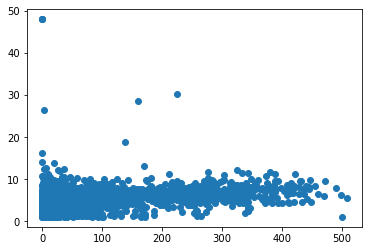

In [47]:
plt.scatter(df_reduced.msg_per_min, df_reduced.duration_hrs)
plt.show()

In [48]:
pearsonr(df_reduced.msg_per_min, df_reduced.duration_hrs)

(0.18627881340871996, 1.114463546358351e-25)

## Distribution of message densities in matches of Fu et. al dataset

In [49]:
chd = ChatHighlightData(chat_dir="../data/final_data", highlight_dir="../data/gt",)
chd.load_data(file_identifier="nalcs*")

In [50]:
data_totals = chd.get_data_totals()

In [51]:
data_totals["chat_message_count"]/(data_totals["video_length_secs"]/60)

174.60866602711147

characteristics of message counts per video where one __video__ is one __match__ in the tournament

In [52]:
msg_counts =  list()
video_lengths = list()
for match, data in chd.chat.items():
    msg_counts.append(len(utils.unpack_messages(data)))
    video_lengths.append(len(data))

In [53]:
np.std(msg_counts)

5364.576250815363

In [54]:
video_lens_mins = np.asarray(video_lengths)/30/60

In [55]:
video_msg_per_min = np.asarray(msg_counts)/video_lens_mins

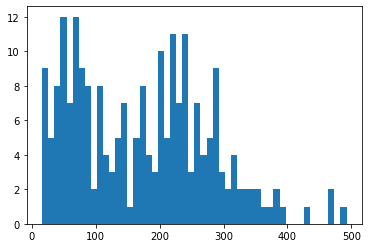

In [56]:
plt.hist(video_msg_per_min,bins=50)
plt.show()

We see two different distributions, inverse to what Bulygin et. al found out about topics. => probably playoffs and finals

[1]D. Bulygin, I. Musabirov, A. Suvorova, K. Konstantinova, and P. Okopnyi, “Between an Arena and a Sports Bar: Online Chats of eSports Spectators,” arXiv:1801.02862 [cs], Dec. 2020, Accessed: Mar. 02, 2022. [Online]. Available: http://arxiv.org/abs/1801.02862

## Selecting VODs based on distributions in our highlight data

We can model the distributions of different features of the videos in our data and then sample VODs based on these criteria until we have a certain amount of tokens

Follow this guide to get the bi-modal distribution out: https://machinelearningmastery.com/probability-density-estimation/

In [57]:
def model_from_samples(s, b):
    # fit density
    sample = s.reshape((-1, 1))
    m = KernelDensity(bandwidth=b, kernel='gaussian')
    return m.fit(s)

In [58]:
def plot_model(v, model):
    # sample probabilities for a range of outcomes
    values = np.arange(0,v.max(),1)
    values = values.reshape((-1, 1))
    probabilities = m.score_samples(values)
    probabilities = np.exp(probabilities)
    
    # plot the histogram and pdf
    plt.hist(v, bins=50, density=True)
    plt.plot(values[:], probabilities)
    plt.show()

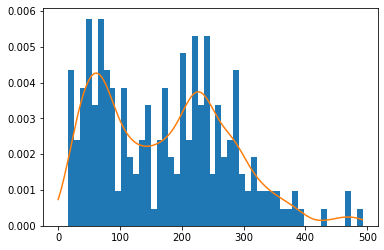

In [59]:
vals = video_msg_per_min.reshape((-1,1))
m = model_from_samples(vals, 20)
plot_model(vals, m)

In [60]:
df_sampled_vids = pd.DataFrame(columns=df_reduced.columns)

while df_sampled_vids.num_tokens.sum() < 5*10**7:
    val = m.sample()[0,0]
    idx = df_reduced.msg_per_min.apply(lambda x: abs(x-val)).idxmin()
    df_sampled_vids = pd.concat([df_sampled_vids, df_reduced[df_reduced.index == idx]])

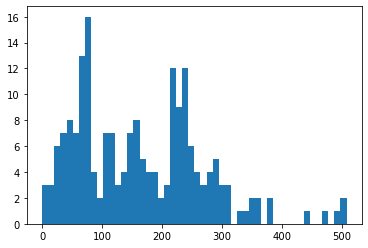

In [61]:
plt.hist(df_sampled_vids.msg_per_min,bins=50)
plt.show()

In [62]:
df_sampled_vids.msg_count.sum(), df_sampled_vids.num_tokens.sum()

(12238818, 50005613)

In [63]:
list(df_sampled_vids.title)

['SB vs. SKT | Playoffs Round 1 | LCK Summer | SANDBOX Gaming vs. SK telecom T1 (2019)',
 'Worlds 2020 Groups: Day 6',
 'JDG vs. LGD | WE vs. EDG | IG vs. LNG - Week 7 Day 7 | LPL Spring (2020)',
 'DK vs KT | NS vs T1 | 2022 LCK Spring Split',
 'LCK Summer: BBQ vs. EEW | SKT vs. MVP',
 'Week 3 Day 1 | LEC Summer Split (2020)',
 'EU LCS Summer (2018) | Week 9 Day 3 (Tiebreakers)',
 'T1 vs HLE | DRX vs KT | 2022 LCK Spring Split',
 'BLG vs. ES | VG vs. WE - Week 3 Day 1 | LPL Summer Split (2020)',
 'T1 vs. DRX - DYN vs. HLE [2020 LCK Summer Split]',
 "Riot Report: Episode 10 - Q&A with Lillia's Designer and New LoR Feature",
 'EU LCS Summer (2018) | Week 1 Day 2',
 'EU LCS Spring: Week 1 Day 1 ',
 'JDG vs. V5 - SS vs. RW Week 6 Day 2 | LPL Spring Split (2019)',
 '[2020 LoL Mid Season Cup] Day 1',
 'LSB vs HLE - DK vs NSㅣ2021 LCK Spring Split',
 'GEN vs DK - HLE vs KTㅣ2021 LCK Spring Split',
 'Title: Riot Report: Episode 7 - VALORANT Closed Beta, and New Legends of Runeterra Cards with Pa